## Apple price prediction

Problem Description - The goal is to train a regression model to predict the average price per kilogram for Golden Delicious Apples from explanatory features

### Importing Libraries

In [1]:
# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

# Model slection
from sklearn.model_selection import train_test_split

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics

# Visualisations
#import missingno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Other
from scipy import stats
import math
import pickle
import pandas as pd
import numpy as np

####  Loading .csv files

In [2]:
# increasing row visability 
pd.set_option('display.max_rows', 65)

In [3]:
#Loading data
test_set = 'df-test_set.csv'
train_set = 'df-train_set.csv'
train = pd.read_csv(train_set)
test = pd.read_csv(test_set)

In [4]:
#Spliting up index column for exporting
index = test['Index']
test = test.drop('Index',axis=1)

### Brief data overview

#### Looking into the data

In [5]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
0,CAPE,EC120,1L,12.0,APPLE GRANNY SMITH,2020-03-10,108.0,112.0,3236.0,29,348.0,0,9.30
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
2,GAUTENG,AT200,1L,20.0,AVOCADO PINKERTON,2020-05-05,70.0,80.0,4860.0,66,1320.0,50,3.68
3,TRANSVAAL,BJ090,1L,9.0,TOMATOES-LONG LIFE,2020-01-20,60.0,60.0,600.0,10,90.0,0,6.67
4,WESTERN FREESTATE,PP100,1R,10.0,POTATO SIFRA (WASHED),2020-07-14,40.0,45.0,41530.0,927,9270.0,393,4.48


In [6]:
train.shape

(64376, 13)

Ok lets drop everything not related to 'APPLE GOLDEN DELICIOUS'.

In [7]:
train = train[train['Commodities'] == 'APPLE GOLDEN DELICIOUS']

In [8]:
train.shape

(1952, 13)

Looks like we drop quite a few rows.

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Commodities       1952 non-null   object 
 5   Date              1952 non-null   object 
 6   Low_Price         1952 non-null   float64
 7   High_Price        1952 non-null   float64
 8   Sales_Total       1952 non-null   float64
 9   Total_Qty_Sold    1952 non-null   int64  
 10  Total_Kg_Sold     1952 non-null   float64
 11  Stock_On_Hand     1952 non-null   int64  
 12  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 213.5+ KB


The info command confirms our categorical and numerical features. If a feature (variable) is categorical the Dtype is object and if it is a numerical variable the Dtype is an int64 or float64. This command also shows us that out of the 64376 none of the features contain any null values.

In [10]:
# K date is an object, will have to look into that.

In [11]:
train.shape

(1952, 13)

 Data comprises of 1952 observationns and 12 characteristics whereby one is dependent variable and 12 are indepedent variables

#### Summary of statistics before data is cleaned

In [12]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


Looking at the describe() nothing looks out of hand, other then the min could be low.

####  Checking for null values

In [13]:
#Checkcing for null values
train.isnull().sum()

Province            0
Container           0
Size_Grade          0
Weight_Kg           0
Commodities         0
Date                0
Low_Price           0
High_Price          0
Sales_Total         0
Total_Qty_Sold      0
Total_Kg_Sold       0
Stock_On_Hand       0
avg_price_per_kg    0
dtype: int64

The dataset contains no nulls.

####  Cleaning the data

To generalize the data a bit more, here we are extracting the month of the date column and then changing it into which season that month corresponds too.

In [14]:
#Convert Date from object to datetime64[ns] 
train["Date"] = pd.to_datetime(train["Date"])
#Extracting month from datetime
train['Date'] = pd.DatetimeIndex(train['Date']).month


#Convert Date from object to datetime64[ns] 
test["Date"] = pd.to_datetime(test["Date"])
#Extracting month from datetime
test['Date'] = pd.DatetimeIndex(test['Date']).month

In [15]:
# # Changing dates from months to seasons
month_list = train['Date'].tolist()

summer = (12,1,2)
autumn = (3,4,5)
winter = (6,7,8)
spring = (9,10,11)
season_list = []

for i in month_list:
    if i in summer:
        season_list.append('summer')
    elif i in autumn:
        season_list.append('autumn')
    elif i in winter:
        season_list.append('winter')
    else:
        season_list.append('spring')

train['Date'] = train['Date'].astype(str)
train['Date'] = season_list

In [16]:
# # Changing dates from months to seasons
month_list = test['Date'].tolist()

summer = (12,1,2)
autumn = (3,4,5)
winter = (6,7,8)
spring = (9,10,11)
season_list = []

for i in month_list:
    if i in summer:
        season_list.append('summer')
    elif i in autumn:
        season_list.append('autumn')
    elif i in winter:
        season_list.append('winter')
    else:
        season_list.append('spring')

test['Date'] = test['Date'].astype(str)
test['Date'] = season_list

####  Summary of Statistics after data is cleaned

In [17]:
train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


Since the data is now cleaned up, now we can look into it. Looking at 75%ith and max values, we see that there is a notable difference between the two. We can also see that the median value is lesser than the mean value. From the two conclusions, we can see that there are extreme outliers in our dataset.

#### Skewdness and Kurtosis

In [18]:
train.skew()

Weight_Kg           3.328254
Low_Price           4.222672
High_Price          3.828819
Sales_Total         4.250317
Total_Qty_Sold      4.445169
Total_Kg_Sold       5.529586
Stock_On_Hand       3.391815
avg_price_per_kg    0.082452
dtype: float64

We can deduce from the skewness of the data that all features are highly positively skewed.

In [19]:
train.kurtosis()

Weight_Kg            9.109698
Low_Price           17.073369
High_Price          13.630768
Sales_Total         24.200524
Total_Qty_Sold      32.338123
Total_Kg_Sold       45.153801
Stock_On_Hand       14.671224
avg_price_per_kg     1.042921
dtype: float64

From what we can gather, we can see that ALL features having a kurtosis number which is well above 3, indicating a high number of outliers.

### Exploring Numerical Features

#### Boxplots and distribution plots

C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an ax

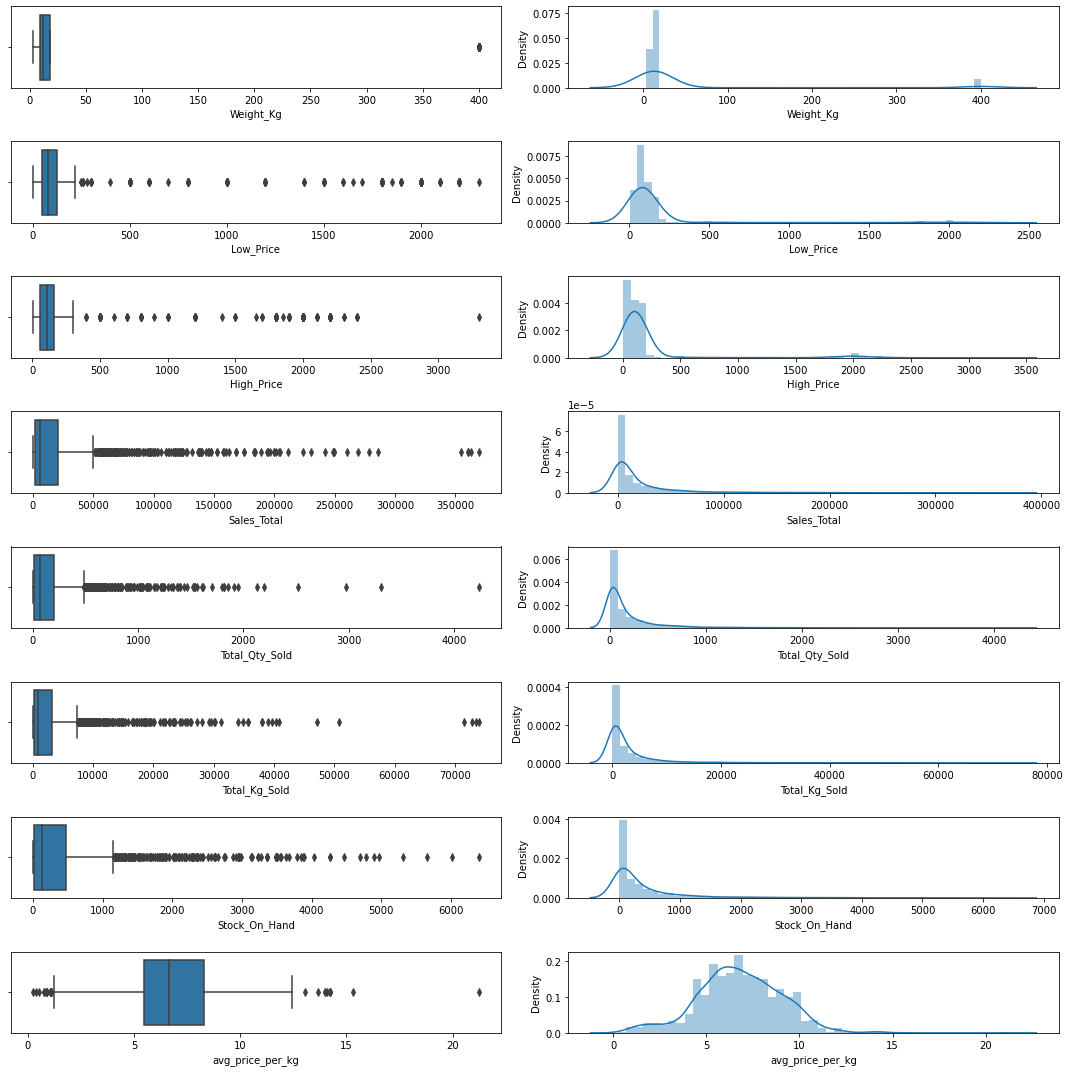

In [20]:
fig, ax = plt.subplots(8, 2, figsize = (15, 15))
sns.boxplot(x= train["Weight_Kg"], ax = ax[0,0])
sns.distplot(train['Weight_Kg'], ax = ax[0,1])
sns.boxplot(x= train["Low_Price"], ax = ax[1,0])
sns.distplot(train['Low_Price'], ax = ax[1,1])
sns.boxplot(x= train["High_Price"], ax = ax[2,0])
sns.distplot(train['High_Price'], ax = ax[2,1])
sns.boxplot(x= train["Sales_Total"], ax = ax[3,0])
sns.distplot(train['Sales_Total'], ax = ax[3,1])
sns.boxplot(x= train["Total_Qty_Sold"], ax = ax[4,0])
sns.distplot(train['Total_Qty_Sold'], ax = ax[4,1])
sns.boxplot(x= train["Total_Kg_Sold"], ax = ax[5,0])
sns.distplot(train['Total_Kg_Sold'], ax = ax[5,1])
sns.boxplot(x= train["Stock_On_Hand"], ax = ax[6,0])
sns.distplot(train['Stock_On_Hand'], ax = ax[6,1])
sns.boxplot(x= train["avg_price_per_kg"], ax = ax[7,0])
sns.distplot(train['avg_price_per_kg'], ax = ax[7,1])
plt.tight_layout()

From the boxplots we can observe that our data is outside the distribution indicating the presence of extreme outliers. the distribution graph shows us that the data is positively/right skewed which means that the average price is higher than than the mean price of apples. Impying more than half of the books are priced lower than the average prices of apples.

#### Histograms

array([[<AxesSubplot:title={'center':'Weight_Kg'}>,
        <AxesSubplot:title={'center':'Low_Price'}>,
        <AxesSubplot:title={'center':'High_Price'}>],
       [<AxesSubplot:title={'center':'Sales_Total'}>,
        <AxesSubplot:title={'center':'Total_Qty_Sold'}>,
        <AxesSubplot:title={'center':'Total_Kg_Sold'}>],
       [<AxesSubplot:title={'center':'Stock_On_Hand'}>,
        <AxesSubplot:title={'center':'avg_price_per_kg'}>,
        <AxesSubplot:>]], dtype=object)

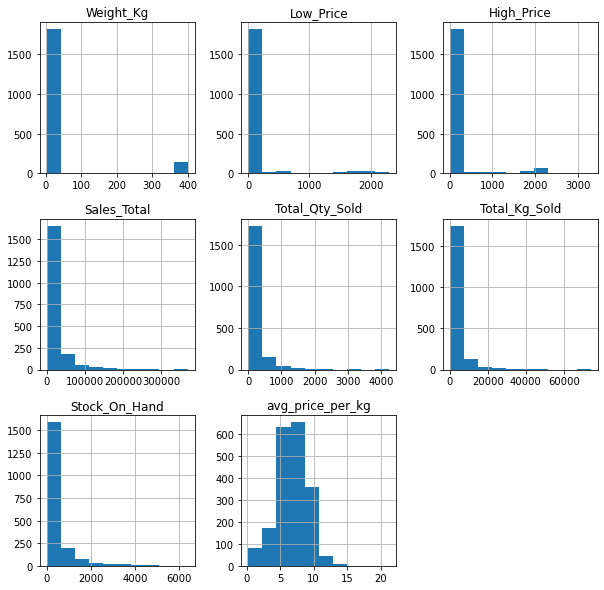

In [21]:
features = ['Weight_Kg', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand', 'avg_price_per_kg'] # create a list of all numerical features
train[features].hist(figsize=(10,10))

If we look at the histogram, we notice that the distribution graph and histogram shows the same pattern which checking for normality

### Exploring Categorical Features

#### Bargraphs

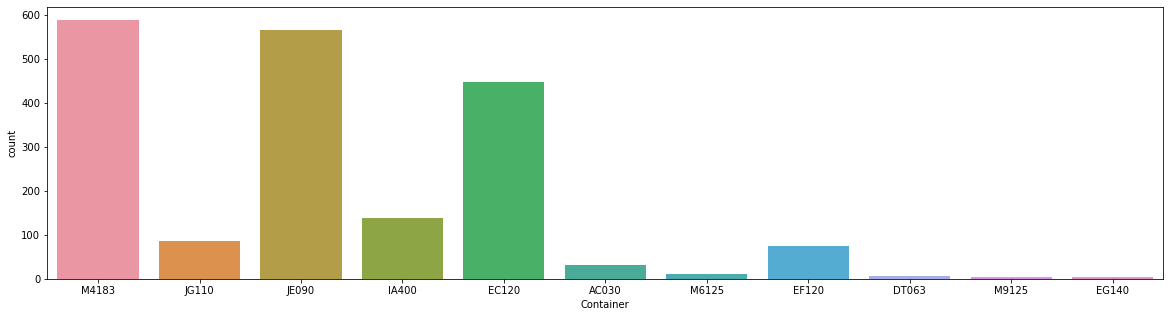

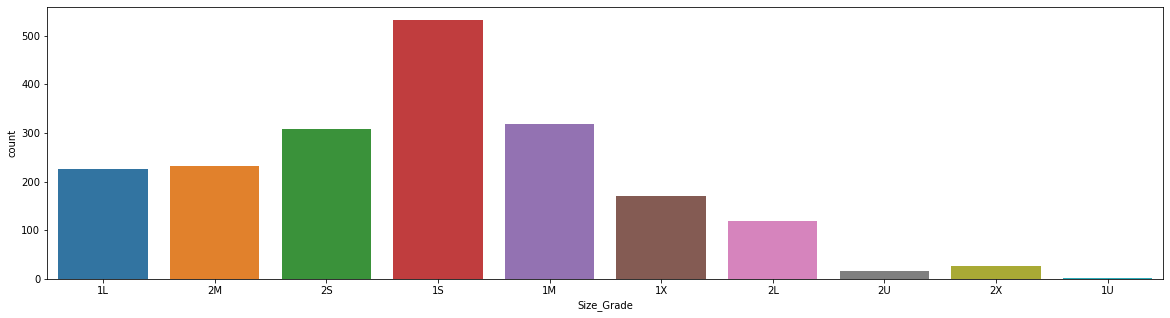

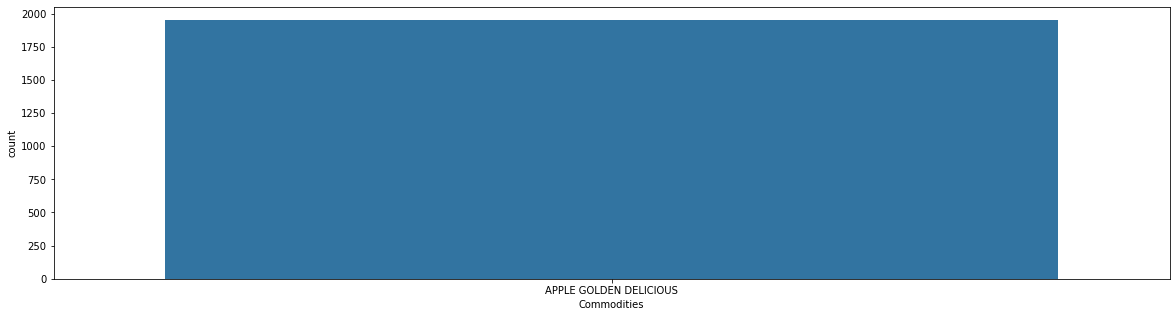

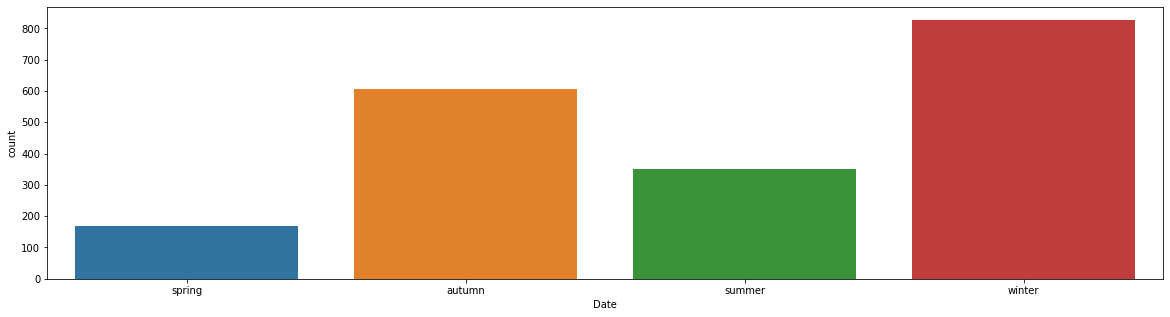

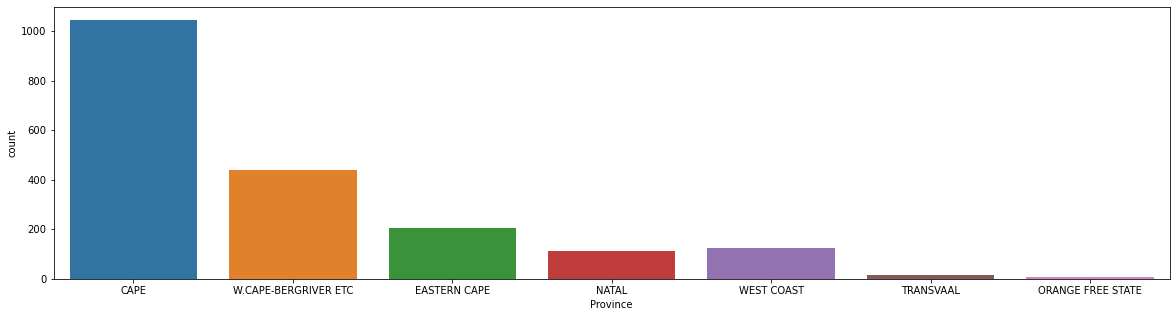

In [22]:
features = ['Container','Size_Grade','Commodities','Date','Province']

for i in features:
    plt.figure(figsize=(20, 5))
    sns.countplot(data= train, x= i)

In [23]:
train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,spring,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,autumn,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,autumn,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,autumn,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,spring,1800.0,1800.0,1800.0,1,400.0,2,4.50


### Checking for Multicollinearity

#### Pairwise

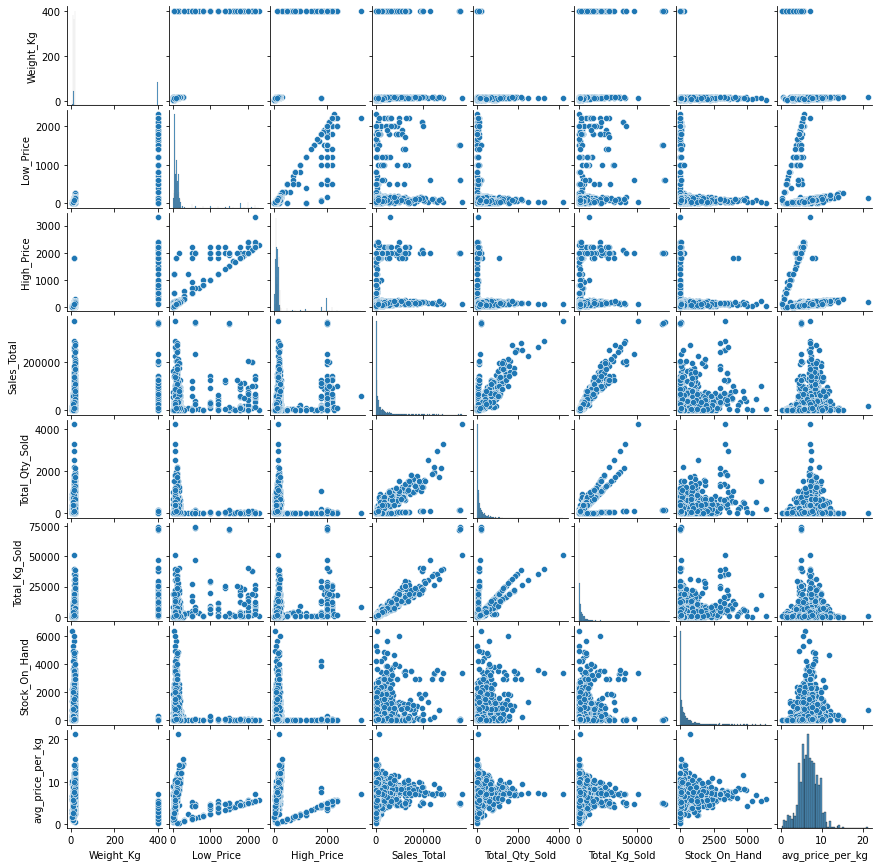

In [24]:
# Due to the number of visuals created, this codeblock takes about one minute to run.
from seaborn import pairplot
g = pairplot(train)
g.fig.set_size_inches(12,12)

#### Correlation heatmap

<AxesSubplot:>

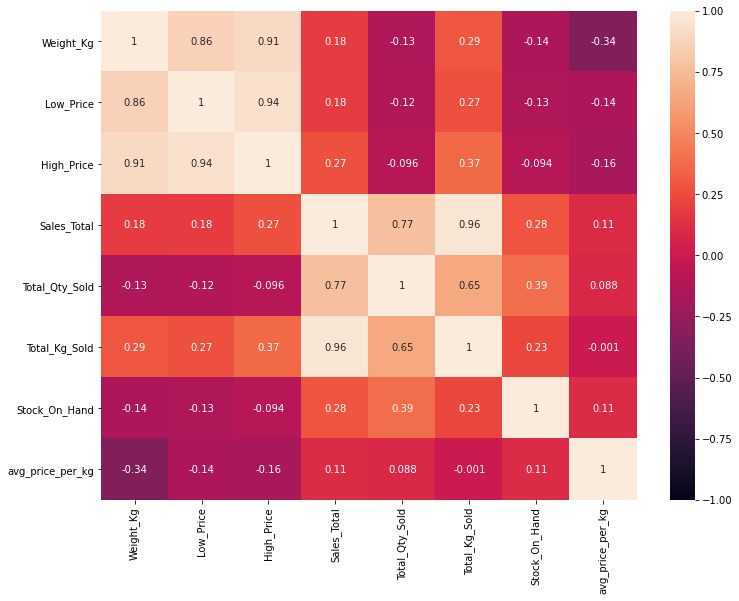

In [25]:
#Correlations
plt_size = (12, 9)
fig, ax = plt.subplots(figsize=plt_size)
sns.heatmap(train.corr(), vmin=-1, vmax=1,annot=True)

Relationship between the average price per kg of apples and other features

- We can see that high_price and low_price has a strong postive relatiopship. This violates the non-multicollinearity assumption of Linear regression.Multicollinearity hinders the performance and accuracy of our regression model. To avoid this, we have to get rid of some of these variables by doing feature selection.
- We also notice a weak positive relationship on sales_total and Total_Kg_Sold
- Lastly, we can see that Total_Qty_Sold, Stock_Hand and Weight_kg has a negative weak relationship impying that they are not highly correlated 

### Feature Selection

#### Dropping columns

Droping Low and High Price, they have too high of a correlation to each other and a low correlation with avg_price_per_kg.

In [26]:
# Droping these columns because they have low correlation with the DV and too high corr with each other
train = train.drop(['Low_Price','High_Price'],axis=1)
test = test.drop(['Low_Price','High_Price'],axis=1)

Droping these columns because they appear to add no value to the models predictive accuracy.

In [27]:
# # Pruning a few more columns, because they do not lower the MSE score for the model
train = train.drop(['Container','Province','Stock_On_Hand'],axis=1) # 
test = test.drop(['Container','Province','Stock_On_Hand'],axis=1)

C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

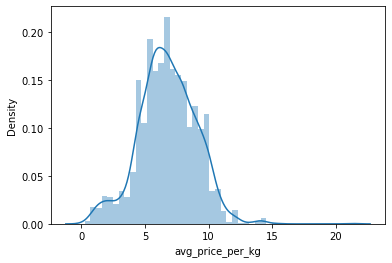

In [28]:
# Distribution
sns.distplot(train['avg_price_per_kg'],kde=True)

In [29]:
# Appears to be some outliers

In [30]:
train.shape

(1952, 8)

In [31]:
# #Distribution tuning
train = train[train['avg_price_per_kg'] < 15] # 15
train = train[train['avg_price_per_kg'] > 1]  # 1

C:\Users\Matthew\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

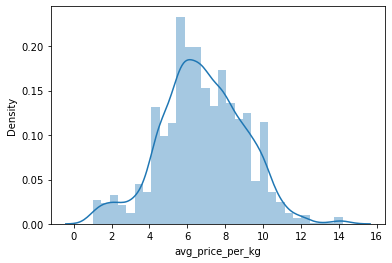

In [32]:
sns.distplot(train['avg_price_per_kg'],kde=True)

In [33]:
train.describe()

,Weight_Kg,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,avg_price_per_kg
count,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000
mean,39.399485,20146.090628,175.376416,2972.075747,6.792230
std,97.879474,39082.746311,309.367827,6110.713342,2.187117
min,3.000000,5.000000,1.000000,3.000000,1.030000
25%,9.000000,1350.000000,13.000000,219.600000,5.460000
50%,12.000000,5585.000000,64.000000,863.250000,6.670000
75%,18.300000,21274.000000,200.000000,3113.250000,8.280000
max,400.000000,369464.000000,4237.000000,74000.000000,14.210000


#### Correlation and Variable Selection

In [34]:
train.corr()

,Weight_Kg,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,avg_price_per_kg
Weight_Kg,1.000000,0.189827,-0.130105,0.303900,-0.323161
Sales_Total,0.189827,1.000000,0.771591,0.962367,0.107472
Total_Qty_Sold,-0.130105,0.771591,1.000000,0.651130,0.086464
Total_Kg_Sold,0.303900,0.962367,0.651130,1.000000,-0.003111
avg_price_per_kg,-0.323161,0.107472,0.086464,-0.003111,1.000000


In [35]:
# # Pruning a few more columns, because they do not lower the MSE score for the model
# train = train.drop(['Stock_On_Hand','Container','Province'],axis=1)
# test = test.drop(['Stock_On_Hand','Container','Province'],axis=1)

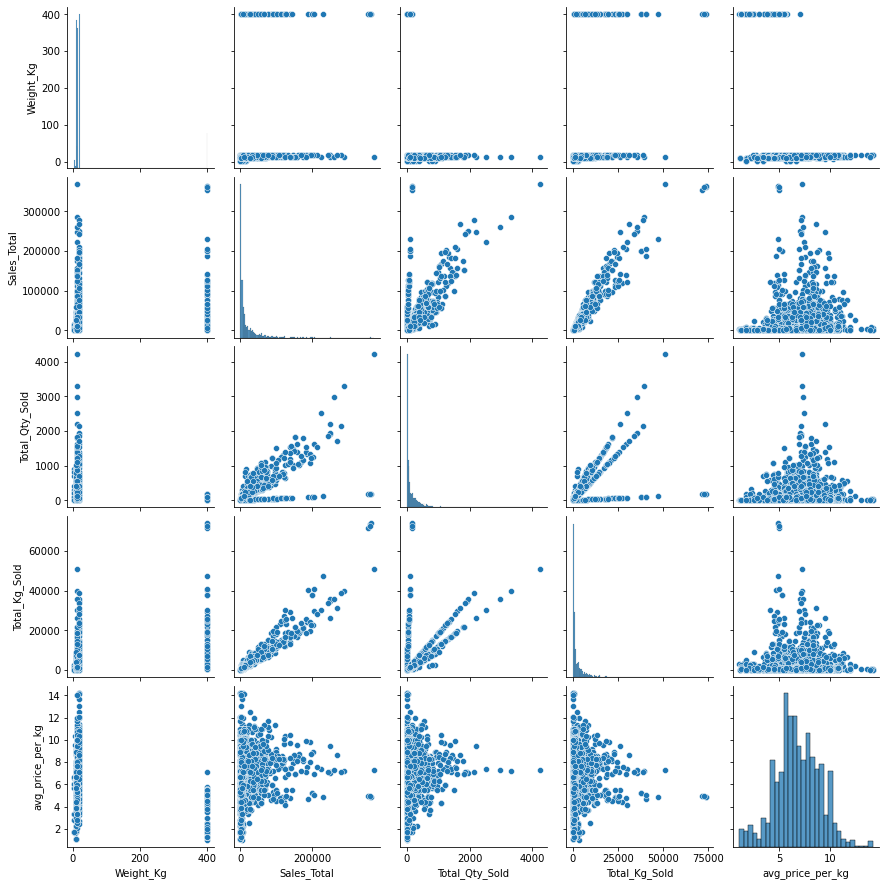

In [36]:
# Corr
sns.pairplot(train)
plt.show()

### Feature Engineering

#### Dummy Variable

In [37]:
# Creating dummy variables for the categorical data
train_dummies = pd.get_dummies(train, drop_first=True)

# Changing column names to prevent errors
train_dummies.columns = [col.replace(" ","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace(")","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace("(","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace("-","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace(".","_") for col in train_dummies.columns]
train_dummies.columns = [col.replace("/","_") for col in train_dummies.columns]

In [38]:
train = train_dummies

In [39]:
train_dummies.shape

(1942, 17)

#### Separating y from X variables

In [40]:
# split predictors and response
y = train['avg_price_per_kg']
X = train.drop(['avg_price_per_kg'], axis=1)

#### Data overview the model using statsmodels.OLS

Using statsmodels to take a look at how each of the features are affecting the variable we would like to predict.

In [41]:
from statsmodels.formula.api import ols

# Model DataFrame with all of the columns:
dfm = train.copy()

# The dependent variable:
y_name = 'avg_price_per_kg'
# The independent variable
# (let's first try all of the columns in the model DataFrame)
X_names = [col for col in dfm.columns if col != y_name]

# Build the OLS formula string " y ~ X "
formula_str = y_name+" ~ "+" + ".join(X_names);
print('Formula:\n\t {}'.format(formula_str))

Formula:
	 avg_price_per_kg ~ Weight_Kg + Sales_Total + Total_Qty_Sold + Total_Kg_Sold + Size_Grade_1M + Size_Grade_1S + Size_Grade_1U + Size_Grade_1X + Size_Grade_2L + Size_Grade_2M + Size_Grade_2S + Size_Grade_2U + Size_Grade_2X + Date_spring + Date_summer + Date_winter


In [42]:
# Fit the model using the model dataframe
model=ols(formula=formula_str, data=dfm)
fitted = model.fit()

# Output the fitted summary
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_price_per_kg   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     118.1
Date:                Wed, 26 May 2021   Prob (F-statistic):          1.45e-271
Time:                        18:07:59   Log-Likelihood:                -3610.7
No. Observations:                1942   AIC:                             7255.
Df Residuals:                    1925   BIC:                             7350.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.7046      0.124     62.

In [43]:
# Calculate correlations between predictor variables and the response variable
corrs = train.corr()['avg_price_per_kg'].sort_values(ascending=False)

In [44]:
from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'avg_price_per_kg']
for col in X:
    p_val = round(pearsonr(X[col], y)[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}
    
df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value'] <=0.05]

,Correlation_Coefficient,P_Value
Weight_Kg,-0.323161,0.000000
Size_Grade_1M,0.178584,0.000000
Size_Grade_1X,0.250964,0.000000
Size_Grade_2M,-0.160401,0.000000
Size_Grade_2S,-0.349250,0.000000
Date_summer,0.198702,0.000000
Sales_Total,0.107472,0.000002
Size_Grade_2L,-0.094079,0.000033
Total_Qty_Sold,0.086464,0.000136
Size_Grade_2U,-0.072173,0.001459


In [45]:
# List of columns where p value is statistically significant
p = df_cp_sorted[df_cp_sorted['P_Value'] < 0.05]
p = p.index

In [46]:
p

Index(['Weight_Kg', 'Size_Grade_1M', 'Size_Grade_1X', 'Size_Grade_2M',
       'Size_Grade_2S', 'Date_summer', 'Sales_Total', 'Size_Grade_2L',
       'Total_Qty_Sold', 'Size_Grade_2U', 'Date_winter'],
      dtype='object')

### Prepping Test Data

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size_Grade      685 non-null    object 
 1   Weight_Kg       685 non-null    float64
 2   Commodities     685 non-null    object 
 3   Date            685 non-null    object 
 4   Sales_Total     685 non-null    float64
 5   Total_Qty_Sold  685 non-null    int64  
 6   Total_Kg_Sold   685 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 37.6+ KB


If there is a dimensional mismatch in test to training dataset, this will remove columns that do not appear in one or the other.

In [48]:
# Creating dummy variables for the categorical data
test_dummies = pd.get_dummies(test, drop_first=True)

In [49]:
test = test_dummies

In [50]:
# List of columns names
test_list = test.columns.unique()

In [51]:
# Modifing X data
# Removing columns that are not in the test data

for i in X:
    if i in test_list:
        pass
    else:
        X = X.drop(i,axis=1)

In [52]:
X.shape

(1942, 16)

In [53]:
# Pruning test dimensions
# Removing columns that do not apear in train data
X_dimensions = X.columns.tolist()

for i in test:
    if i in X_dimensions:
        pass
    else:
        test = test.drop(i,axis=1)

In [54]:
test.shape

(685, 16)

#### Implementing Scaling
Creating Standardize versions of X, aswell as test data

In [55]:
# Create scaler object
scaler = StandardScaler()

In [56]:
# Create scaled version of the predictors (there is no need to scale the response)
X_standardise = scaler.fit_transform(X)

In [57]:
# create scaled version test data as well for later use
X_standardise_test = scaler.fit_transform(test)

### Creating train and testing data sets for model's

In [58]:
# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=12)

In [59]:
# Standardize
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

### Features Importances

Creating a random forset so we can see what it believes are the important features.

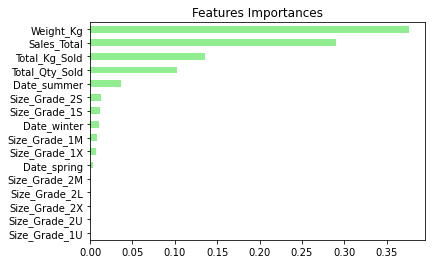

In [60]:
RFfi = RandomForestRegressor(n_estimators=30, max_depth=20,random_state=23)
RFfi.fit(X_train, y_train)

# Create a pd.Series of features importances
importances = pd.Series(data=RFfi.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

Droping all features that are below 0.05.

In [61]:
important_f = importances_sorted[importances_sorted > 0.05].index

In [62]:
important_f

Index(['Total_Qty_Sold', 'Total_Kg_Sold', 'Sales_Total', 'Weight_Kg'], dtype='object')

In [63]:
for i in X:
    if i in important_f:
        pass
    else:
        X = X.drop(i,axis=1)

for j in test:
    if j in X:
        pass
    else:
        test = test.drop(j,axis=1)

Creating new train and test sets with the updated X dataset.

In [64]:
# Updateing split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=12)



In [65]:
X_standardise = scaler.fit_transform(X)
# create scaled version test data as well for later use
X_standardise_test = scaler.fit_transform(test)

In [66]:
# Standardize
s_X_train, s_X_test, s_y_train, s_y_test = train_test_split(X_standardise, 
                                                    y, 
                                                    test_size=0.20, 
                                                    random_state=42)

## Multivariate Regression Model

### Linear Regression in Sklearn

Regression models describe the relationship between variables by fitting a line to the observed data. Linear regression models use a straight line, while logistic and nonlinear regression models use a curved line. Regression allows you to estimate how a dependent variable changes as the independent variable(s) change.

Creating two instances of the LinearRegression() object with all the default parameters.

In [67]:
lm = LinearRegression()
lms = LinearRegression()

At this stage, all we have done is initialise a model of the form:  𝑦=𝑎+𝑏𝑥.
With the object created, we will then need to fit the model to our data. This is done using the .fit() function.

In [68]:
# train model
lm.fit(X_train, y_train)
# training model with standardized X
lms.fit(s_X_train, s_y_train)

LinearRegression()

In [69]:
# extract model intercept
beta_0 = float(lm.intercept_)
beta_0s = float(lms.intercept_)

In [70]:
print("Intercept:", beta_0)
print("Intercept_S:", beta_0s)

Intercept: 7.058889508606785
Intercept_S: 6.790830269313548


In [71]:
# extract model coeffs
beta_js = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])
beta_js['Coefficient_s'] = lms.coef_

In [72]:
beta_js

,Coefficient,Coefficient_s
Weight_Kg,-0.007001,-0.675065
Sales_Total,0.000123,4.887618
Total_Qty_Sold,-0.004033,-1.270633
Total_Kg_Sold,-0.000591,-3.665516


### Ridge Regression model in Sklearn

Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

In [73]:
# Create ridge models for both data sets
ridge = Ridge()
ridge_s = Ridge()

In [74]:
# Train the model
ridge.fit(X_train, y_train)
ridge_s.fit(s_X_train, s_y_train)

Ridge()

In [75]:
# Extract the models intercept value
b0 = float(ridge.intercept_)
b0_s = float(ridge_s.intercept_)

In [76]:
print("Intercept:", float(b0))
print("Intercept:", float(b0_s))

Intercept: 7.058889477119776
Intercept: 6.790287694873671


In [77]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])
# coeff['Coefficient_s'] = ridge_s.coef_

In [78]:
coeff

,Coefficient
Weight_Kg,-0.007001
Sales_Total,0.000123
Total_Qty_Sold,-0.004033
Total_Kg_Sold,-0.000591


### Decision Tree Regressor in Sklearn

Decision tree builds regression or classification models in the form of a tree structure. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes.

In [79]:
# Instantiate regression tree model
regr_tree = DecisionTreeRegressor(max_depth=50,random_state=42)
regr_tree_s = DecisionTreeRegressor(max_depth=50,random_state=69)

In [80]:
regr_tree.fit(X_train,y_train)
regr_tree_s.fit(s_X_train,s_y_train)

DecisionTreeRegressor(max_depth=50, random_state=69)

### Random Forest Regressor in Sklearn

The random forest is a algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

In [81]:
%%time
# Instantiate regression tree model
RF = RandomForestRegressor(n_estimators=350, max_depth=10,random_state=23)
RF_S = RandomForestRegressor(n_estimators=100, max_depth=50,random_state=23)

Wall time: 0 ns


In [82]:
# Train models
RF.fit(X_train,y_train)
RF_S.fit(s_X_train,s_y_train)

RandomForestRegressor(max_depth=50, random_state=23)

### Boosting a Forest

An AdaBoost regressor. An AdaBoost regressor is a meta-estimator that begins by fitting a regressor on the original dataset and then fits additional copies of the regressor on the same dataset but where the weights of instances are adjusted according to the error of the current prediction.

In [83]:
# Instantiate random forest regression model to use as the base model
brf = RandomForestRegressor(n_estimators=100,max_depth=30,random_state=23,n_jobs=-1)
# Instantiate AdaBoostRegressor model with a random forest as the base model
bbbooost = AdaBoostRegressor(base_estimator = brf,random_state=42)
bbbooosts = AdaBoostRegressor(base_estimator = brf,random_state=42)

In [84]:
%%time
# Training
bbbooost.fit(X_train,y_train)
bbbooosts.fit(s_X_train,s_y_train)

Wall time: 14.1 s


AdaBoostRegressor(base_estimator=RandomForestRegressor(max_depth=30, n_jobs=-1,
                                                       random_state=23),
                  random_state=42)

### Testing
To evaluate the performance of our model, we can report the mean square error or plot predicted output vs actual output.

### MSE Results of models

In [85]:
# dictionary of results
results_dict = {'Training MSE':
                    {
                        "MLR": metrics.mean_squared_error(y_train, lm.predict(X_train)),
                        "MLR_S": metrics.mean_squared_error(s_y_train, lms.predict(s_X_train)),
                        "Ridge": metrics.mean_squared_error(y_train, ridge.predict(X_train)),
                        "Ridge_S": metrics.mean_squared_error(s_y_train, ridge_s.predict(s_X_train)),
                        "Tree": metrics.mean_squared_error(y_train, regr_tree.predict(X_train)),
                        "Tree_S": metrics.mean_squared_error(s_y_train, regr_tree_s.predict(s_X_train)),
                        "RF": metrics.mean_squared_error(y_train, RF.predict(X_train)),
                        "RF_S": metrics.mean_squared_error(s_y_train, RF_S.predict(s_X_train)),
                        "BOOST": metrics.mean_squared_error(y_train, bbbooost.predict(X_train)),
                        "BOOST_S": metrics.mean_squared_error(s_y_train, bbbooosts.predict(s_X_train))
                    },
                'Test MSE':
                    {
                        "MLR": metrics.mean_squared_error(y_test, lm.predict(X_test)),
                        "MLR_S": metrics.mean_squared_error(s_y_test, lms.predict(s_X_test)),
                        "Ridge": metrics.mean_squared_error(y_test, ridge.predict(X_test)),
                        "Ridge_S": metrics.mean_squared_error(s_y_test, ridge_s.predict(s_X_test)),
                        "Tree": metrics.mean_squared_error(y_test, regr_tree.predict(X_test)),
                        "Tree_S": metrics.mean_squared_error(s_y_test, regr_tree_s.predict(s_X_test)),
                        "RF": metrics.mean_squared_error(y_test, RF.predict(X_test)),
                        "RF_S": metrics.mean_squared_error(s_y_test, RF_S.predict(s_X_test)),
                        "BOOST": metrics.mean_squared_error(y_test, bbbooost.predict(X_test)),
                        "BOOST_S": metrics.mean_squared_error(s_y_test, bbbooosts.predict(s_X_test))
                        
                    },
                'Test RMSE':
                    {
                        "MLR": math.sqrt(metrics.mean_squared_error(y_test, lm.predict(X_test))),
                        "MLR_S": math.sqrt(metrics.mean_squared_error(s_y_test, lms.predict(s_X_test))),
                        "Ridge": math.sqrt(metrics.mean_squared_error(y_test, ridge.predict(X_test))),
                        "Ridge_S": math.sqrt(metrics.mean_squared_error(s_y_test, ridge_s.predict(s_X_test))),
                        "Tree": math.sqrt(metrics.mean_squared_error(y_test, regr_tree.predict(X_test))),
                        "Tree_S": math.sqrt(metrics.mean_squared_error(s_y_test, regr_tree_s.predict(s_X_test))),
                        "RF": math.sqrt(metrics.mean_squared_error(y_test, RF.predict(X_test))),
                        "RF_S": math.sqrt(metrics.mean_squared_error(s_y_test, RF_S.predict(s_X_test))),
                        "BOOST": math.sqrt(metrics.mean_squared_error(y_test, bbbooost.predict(X_test))),
                        "BOOST_S": math.sqrt(metrics.mean_squared_error(s_y_test, bbbooosts.predict(s_X_test)))
                    }
                }

In [86]:
# create dataframe from dictionary
results_df = pd.DataFrame(data=results_dict)

In [87]:
results_df

,Training MSE,Test MSE,Test RMSE
MLR,3.455600e+00,3.087903,1.757243
MLR_S,3.273593e+00,3.816670,1.953630
Ridge,3.455600e+00,3.087903,1.757243
Ridge_S,3.274341e+00,3.812413,1.952540
Tree,2.336613e-32,0.494307,0.703070
Tree_S,1.117511e-32,0.556051,0.745688
RF,4.699840e-01,0.739661,0.860035
RF_S,4.878040e-02,0.360461,0.600384
BOOST,1.261640e-02,0.245290,0.495267
BOOST_S,1.166745e-02,0.289657,0.538198


In [88]:
#BOOST	1.030750e-02	0.222202	0.471383

### Plotting predicted vs actual 

Creating scatter plot of predicts vs actuals.

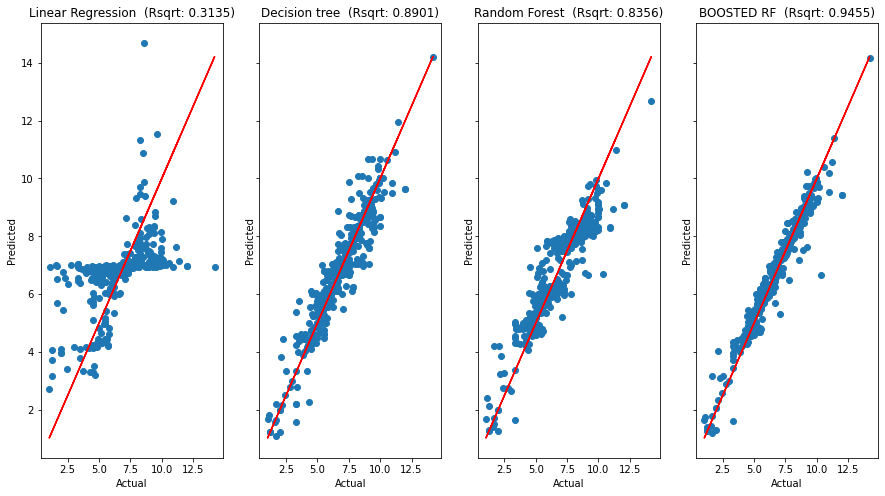

In [97]:
# Plotting tree y_test vs y_pred

# Create figure and axes
f, ax = plt.subplots(figsize=(15,8), nrows=1, ncols=4, sharey=True)

# Create list of titles and predictions to use in for loop
pred = [lm.predict(X_test), regr_tree.predict(X_test), RF.predict(X_test), bbbooost.predict(X_test)] # 
title = ['Linear Regression','Decision tree', 'Random Forest','BOOSTED RF'] # 
r_score = [lm.score(X_test, y_test), regr_tree.score(X_test, y_test), RF.score(X_test, y_test), bbbooost.score(X_test, y_test)]

# Loop through all axes to plot each model's results 
for i in range(4):
    rsquared = round(r_score[i],4)
    ax[i].set_title(title[i]+"  (Rsqrt: "+str(rsquared)+ ")")
    ax[i].set_xlabel('Actual')
    ax[i].set_ylabel('Predicted')
    ax[i].plot(y_test,y_test,'r')
    ax[i].scatter(y_test,pred[i]) 

As we can see from the above graphs and MSE scores the Linear model does not fit the regression line well at all and the Tree models are doing so much better. We can see that the adaboosted random forest fits the regression line the closest. So it will be the chosen model for the prediction of Avg apple prices.

#### Predictions using test data

In [90]:
# Predictions
boost = bbbooost.predict(test)

In [91]:
# boost

#### Export csv

In [92]:
# create submission dataframe
# Create Dataframe of Order_No and Time from Pickup to Arrival
submission = pd.DataFrame(
    {'Index': index,
     'avg_price_per_kg': boost
    })

In [93]:
# save DataFrame to csv file for submission
submission.to_csv("full set.csv", index=False)

### Saving a model with Pickle

In [94]:
import pickle

model_save_path = "model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(regr_tree,file)

In [95]:
# best model isnt in the pickle because of size